In [1]:
%matplotlib inline
import Constants as C
from MakeModels import *
encoder = makeEncoder(C.batchSz)
decoder = makeDecoder()
autoencoder = makeAutoencoder(encoder,decoder)

autoencoder.load_weights('/home/ubuntu/SoftRobotRepresentation/ModelPrettyGoodBottleneck25.h5', by_name=True)

imageLSTM = makeImageLSTM(encoder)

Using TensorFlow backend.


(None, 25)
(1, None, 27)
(1, 512)
(1, 2)


In [ ]:
from IPython.display import SVG,display
from keras.utils.visualize_util import model_to_dot

display(SVG(model_to_dot(imageLSTM,show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
## Let's test some learning rates
import numpy as np
from numpy import random
import tqdm
from IPython.core.debugger import Pdb
from matplotlib import pyplot as plt

import pandas as pd


numEpochs = 50
numBatchesPerEpoch = 1000
nValBatches = 100

trainPath = "/home/ubuntu/SoftRobotRepresentation/Data/Training/0/"
valPath = "/home/ubuntu/SoftRobotRepresentation/Data/Validation/0/"

positionFiles = ['/home/ubuntu/SoftRobotRepresentation/Data/recordingRight.csv',
                 '/home/ubuntu/SoftRobotRepresentation/Data/recordingRight2.csv']

numFramesTrain = [21420,31430]
numFramesVal = [9180,13470]
numFrames = [e+f for e,f in zip(numFramesTrain,numFramesVal)]

posTables = [pd.read_csv(e) for e in positionFiles]

positionDataTrain = np.empty(shape=(0,2))
positionDataVal = np.empty(shape=(0,2))
for i in range(len(positionFiles)):
    positionData = posTables[i].as_matrix(columns=['x(m)','y(m)'])
    positionDataTrain = np.concatenate((positionDataTrain,positionData[:numFramesTrain[i],:]))
    positionDataVal = np.concatenate((positionDataVal,positionData[numFramesTrain[i]:numFrames[i],:]))
    
print str(positionDataTrain.shape) +" " + str(positionDataVal.shape)

def trainGenerator():
    files = os.listdir(trainPath)
    files = ['%s%06d.jpg'%(trainPath,i) for i in range(len(files))]
    res = np.zeros(shape=(C.timeSz,imDim,imDim,3))
    while True:
        for i in range(numBatchesPerEpoch):
            resPos = positionDataTrain[i*C.timeSz:(i+1)*(C.timeSz),:]
            for j in range(C.timeSz):
                index = i*C.timeSz+j
                res[j,:] = plt.imread(files[index]).astype('float32')/255.0
                
            posRes = positionDataTrain[i*C.timeSz+C.predictAhead:(i+1)*C.timeSz+C.predictAhead,:]
            yield ([resPos,res],posRes)
        
def valGenerator():  
    files = os.listdir(valPath)
    files = ['%s%06d.jpg'%(valPath,i) for i in range(len(files))]
    res = np.zeros(shape=(C.timeSz,imDim,imDim,3))
    while True:
        for i in range(nValBatches):
            resPos = positionDataVal[i*C.timeSz:(i+1)*(C.timeSz),:]
            for j in range(C.timeSz):
                index = i*C.timeSz+j
                res[j,:] = plt.imread(files[index]).astype('float32')/255.0
                
            posRes = positionDataVal[i*C.timeSz+C.predictAhead:(i+1)*C.timeSz+C.predictAhead,:]
            yield ([resPos,res],posRes)
            
            

def trainGeneratorPlainPos():
    res = np.zeros(shape=(C.timeSz,2))
    while True:
        for i in range(numBatchesPerEpoch):
            res = positionDataTrain[i*C.timeSz:i*(C.timeSz+1),:]
            posRes = positionDataTrain[i*(C.timeSz+1)+C.predictAhead,:]
            yield (res,posRes)
        
def valGenerator():  
    res = np.zeros(shape=(C.timeSz,2))
    while True:
        for i in range(nValBatches):
            res = positionDataVal[i*C.timeSz:i*(C.timeSz+1),:]
            posRes = positionDataVal[i*(C.timeSz+1)+C.predictAhead,:]
            yield (res,posRes)

In [ ]:
## Let's test some learning rates
from keras.optimizers import Adam
import numpy as np
from numpy import random
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau


lr = 5e-2
print "Learning rate=" + str(lr)
print "Compiling model"
imageLSTM.compile(optimizer=Adam(lr=lr),loss='mse')
print "Done compiling model"
history = imageLSTM.fit_generator(generator=trainGenerator(),
                                    samples_per_epoch=numBatchesPerEpoch*C.timeSz,
                                    nb_epoch=numEpochs,
                                    validation_data=valGenerator(),
                                    nb_val_samples=nValBatches*C.timeSz,
                                    callbacks=[TensorBoard(log_dir='/home/ubuntu/SoftRobotRepresentation/Data/Logs/0'),
                                               ModelCheckpoint('/home/ubuntu/SoftRobotRepresentation/LSTMModel.h5'),
                                               ReduceLROnPlateau(factor=0.2,patience=2)]
                                   )

In [2]:
import math
import numpy as np
from IPython.core.debugger import Pdb
from random import shuffle

C.batchSz = 64

def generator(path,shuf=False,numFrames=None):
    masterList = np.load(path)
    nFeatures = masterList.shape[1]-2
        
    X = np.zeros((C.batchSz,C.timeSz,nFeatures))
    y = np.zeros((C.batchSz,2))
    while True:
        for i in range(int(masterList.shape[0]/C.batchSz)-1):
            baseIndices = np.arange(i*C.batchSz,(i+1)*C.batchSz)
            if(shuf):
                baseIndices = np.random.randint(0,masterList.shape[0]-C.timeSz,size=(C.batchSz,))
            fail = False
            for j in range(C.batchSz):
                bi = baseIndices[j]
                if numFrames is not None and numFrames in np.arange(bi,bi+C.timeSz):
                    fail = True
                X[j,:,:] = masterList[bi:bi+C.timeSz,:-2]
                y[j,:] = masterList[bi+C.timeSz-1,-2:]    
            if not fail:
                yield (X,y)

In [ ]:
paths = ['/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy','/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy']
gengen = generator(paths[0],shuf=True)
gengen.next()

In [3]:
from MakeModels import *

nFeatures = autoencoder.layers[-2].output_shape[-1]+2
featureLSTM = makeFeatureLSTM(nFeatures)

In [ ]:
from IPython.display import SVG,display
from keras.utils.visualize_util import model_to_dot

display(SVG(model_to_dot(featureLSTM,show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
## Let's test some learning rates
from keras.optimizers import Adam
import numpy as np
from numpy import random
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
import shutil

trainPath = '/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy'
valPath = '/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy'

numEpochs = 2000
numBatchesPerEpoch = 500
nValBatches = 500

nFramesTrain = 21420
nFramesVal = 9180
featureLSTM.load_weights('/home/ubuntu/SoftRobotRepresentation/featureLSTMModel1.h5')


lr = 2.5e-1
print "Learning rate=" + str(lr)
print "Compiling model"


if(os.path.isdir('/home/ubuntu/SoftRobotRepresentation/Data/Logs/')):
    shutil.rmtree('/home/ubuntu/SoftRobotRepresentation/Data/Logs/')

featureLSTM.compile(optimizer=Adam(lr=lr),loss='mse')
print "Done compiling model"
history = featureLSTM.fit_generator(generator=generator(trainPath,shuf=False,numFrames=nFramesTrain),
                                    samples_per_epoch=numBatchesPerEpoch*C.batchSz,
                                    nb_epoch=numEpochs,
                                    validation_data=generator(valPath,shuf=False,numFrames=nFramesVal),
                                    nb_val_samples=nValBatches*C.batchSz,
                                    callbacks=[TensorBoard(log_dir='/home/ubuntu/SoftRobotRepresentation/Data/Logs/1'),
                                               ModelCheckpoint('/home/ubuntu/SoftRobotRepresentation/featureLSTMModel.h5'),
                                               ReduceLROnPlateau(factor=0.5,patience=4)]
                                   )

In [ ]:
from matplotlib import pyplot as plt

import pandas as pd


paths = ['/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy','/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy']
gengen = generator(paths[0],shuf=False)

nPoints = 1024
res = np.zeros((nPoints,2))
res3 = np.zeros((nPoints,2))

for i in range(nPoints/C.batchSz):
    bluff = gengen.next()
    stuff = bluff[0]
    cruff = bluff[1]
    
    res[i*C.batchSz:(i+1)*C.batchSz,:] = stuff[:,0,-2:]
    res3[i*C.batchSz:(i+1)*C.batchSz,:] = cruff
    
gengen = generator(paths[0],shuf=False)
res2 = np.zeros((nPoints,2))    
for i in range(nPoints/C.timeSz):
    stuff = gengen.next()
    stuff = stuff[0]
    
    res2[i*C.timeSz:(i+1)*C.timeSz,:] = stuff[0,:,-2:]
    
    for j in range(C.timeSz/C.batchSz - 1):
        gengen.next()
    

xvals = np.arange(res.shape[0])    
plt.figure(1)
plt.plot(xvals,res[:,-1],xvals,res[:,-2],xvals, res3[:,-1], xvals, res3[:,-2])

plt.figure(2)
plt.plot(xvals,res2[:,-1],xvals,res2[:,-2])


posTable = pd.read_csv('/home/ubuntu/SoftRobotRepresentation/Data/recordingRight.csv')
positionData = posTable.as_matrix(columns=['x(m)','y(m)'])

plt.figure(3)
# plt.plot(xvals,positionData[xvals,-1],xvals,positionData[xvals,-2])

In [4]:
positionLSTM = makePlainLSTM()

In [5]:
import math
import numpy as np
from IPython.core.debugger import Pdb

C.batchSz = 64

def generatorPos(path,shuf=False,numFrames=None):
    masterList = np.load(path)
    nFeatures = masterList.shape[1]-2
        
    X = np.zeros((C.batchSz,C.timeSz,2))
    y = np.zeros((C.batchSz,2))
    while True:
        for i in range(int(masterList.shape[0]/C.batchSz)-1):
            baseIndices = np.arange(i*C.batchSz,(i+1)*C.batchSz)
            if(shuf):
                baseIndices = np.random.randint(0,masterList.shape[0]-C.timeSz,size=(C.batchSz,))
            fail = False
            for j in range(C.batchSz):
                bi = baseIndices[j]
                if numFrames is not None and numFrames in np.arange(bi,bi+C.timeSz):
                    fail = True
                X[j,:,:] = masterList[bi:bi+C.timeSz,-4:-2]
                y[j,:] = masterList[bi+C.timeSz-1,-2:]   
            if not fail:
                yield (X,y)

In [ ]:
## Let's test some learning rates
from keras.optimizers import Adam
import numpy as np
from numpy import random
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
import shutil

trainPath = '/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy'
valPath = '/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy'

numEpochs = 2000
numBatchesPerEpoch = 500
nValBatches = 500

nFramesTrain = 21420
nFramesVal = 9180

if(os.path.isdir('/home/ubuntu/SoftRobotRepresentation/Data/Logs/')):
    shutil.rmtree('/home/ubuntu/SoftRobotRepresentation/Data/Logs/')

lr = 2.5e-1
print "Learning rate=" + str(lr)
print "Compiling model"
positionLSTM.compile(optimizer=Adam(lr=lr),loss='mse')
print "Done compiling model"
history = positionLSTM.fit_generator(generator=generatorPos(trainPath,shuf=True,numFrames=nFramesTrain),
                                    samples_per_epoch=numBatchesPerEpoch*C.batchSz,
                                    nb_epoch=numEpochs,
                                    validation_data=generatorPos(valPath,shuf=True,numFrames=nFramesVal),
                                    nb_val_samples=nValBatches*C.batchSz,
                                    callbacks=[TensorBoard(log_dir='/home/ubuntu/SoftRobotRepresentation/Data/Logs/1'),
                                               ModelCheckpoint('/home/ubuntu/SoftRobotRepresentation/positionLSTMModel.h5'),
                                               ReduceLROnPlateau(factor=0.5,patience=3)]
                                   )

In [ ]:
from IPython.display import SVG,display
from keras.utils.visualize_util import model_to_dot

display(SVG(model_to_dot(positionLSTM,show_shapes=True).create(prog='dot', format='svg')))

In [6]:
import math
import numpy as np
from IPython.core.debugger import Pdb

C.batchSz = 64

def gep(path,shuf=False,numFrames=None):
    masterList = np.load(path)
    nFeatures = masterList.shape[1]-2
        
    X = np.zeros((C.batchSz,C.timeSz,nFeatures))
    y = np.zeros((C.batchSz,2))
    kk = 0
    while True:
        for i in range(int(masterList.shape[0]/C.batchSz)-1):
            baseIndices = np.arange(i*C.batchSz,(i+1)*C.batchSz)
            if(shuf):
                baseIndices = np.random.randint(0,masterList.shape[0]-C.timeSz,size=(C.batchSz,))
            baseIndices[0] = kk
            kk = kk+1
            fail = False
            for j in range(C.batchSz):
                bi = baseIndices[j]
                if numFrames is not None and numFrames in np.arange(bi,bi+C.timeSz):
                    fail = True
                X[j,:,:] = masterList[bi:bi+C.timeSz,:-2]
                y[j,:] = masterList[bi+C.timeSz-1,-2:]    
            if not fail:
                yield (X,y)

In [7]:
from keras.optimizers import Adam

# positionLSTM.load_weights('/home/ubuntu/SoftRobotRepresentation/positionLSTMModel.h5')
featureLSTM.load_weights('/home/ubuntu/SoftRobotRepresentation/featureLSTMModel1.h5')

from matplotlib import pyplot as plt

import pandas as pd
from tqdm import tqdm

nFramesTrain = 21420
nFramesVal = 9180

paths = ['/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy','/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy']
gengen = gep(paths[1],shuf=True,numFrames=nFramesVal)

print C.batchSz
featureLSTM.compile(optimizer=Adam(lr=1e-1),loss='mse')

blah = featureLSTM.evaluate_generator(gengen, C.batchSz*32)

nPoints = 2048
X = np.zeros((nPoints,2))
y = np.zeros((nPoints,2))
ypred = np.zeros((nPoints,2))
ypredf = np.zeros((nPoints,2))

for i in tqdm(range(nPoints)):
    bluff = gengen.next()
    stuff = bluff[0]
    cruff = bluff[1]
    
#     oup = positionLSTM.predict_on_batch(inp)
    oupf = featureLSTM.predict_on_batch(stuff)
    
    X[i,:] = stuff[0,0,-2:]
    y[i,:] = cruff[0,:]
#     ypred[i*C.batchSz:(i+1)*C.batchSz,:] = oup
    ypredf[i,:] = oupf[0,:]

64


100%|██████████| 2048/2048 [00:36<00:00, 55.96it/s]


In [8]:
blah

0.099511817563325167

(2048, 2)


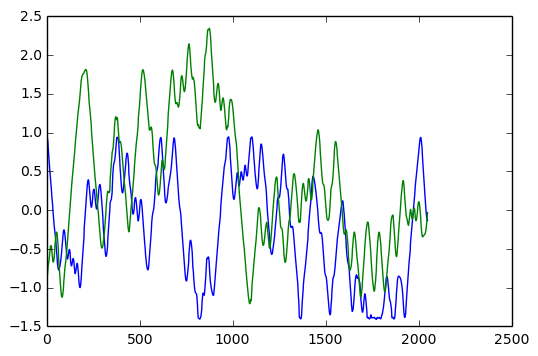

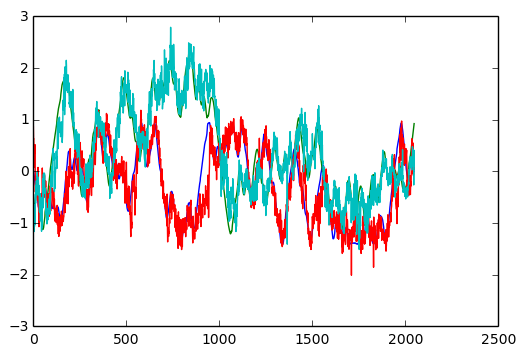

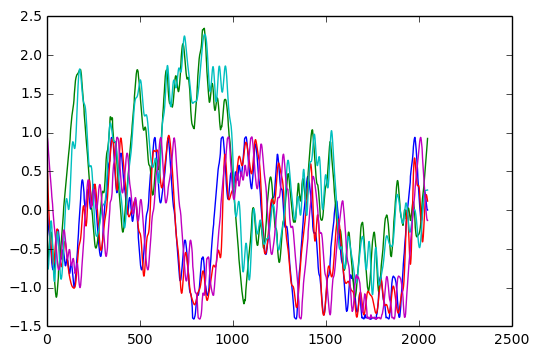

In [10]:
from scipy import signal 

print ypred.shape
[b,a] = signal.butter(10,0.075)
ypredlow = np.zeros_like(ypred)
ypredlow[:,-1] = signal.filtfilt(b,a,ypredf[:,-1])
ypredlow[:,-2] = signal.filtfilt(b,a,ypredf[:,-2])
xvals = np.arange(X.shape[0])    
plt.figure(1)
plt.plot(xvals,X[:,-1],xvals,X[:,-2])
plt.figure(2)
plt.plot(xvals,y[:,-1], xvals, y[:,-2],xvals,ypredf[:,-1],xvals,ypredf[:,-2])
plt.figure(3)
plt.plot(xvals,y[:,-1], xvals, y[:,-2],xvals,ypredlow[:,-1],xvals,ypredlow[:,-2],xvals,X[:,-1])

In [ ]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
from IPython.core.debugger import Pdb

path = get_file('nietzsche.txt', origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")
text = open(path).read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Pdb().set_trace()


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y, batch_size=128, nb_epoch=1)

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()